# Dirty Map Generation Example

In this workbook we demonstrate how to make a dirty map from an input covariance tensor. There are a few methods to do this depending on whether you have one or multiple instruments. The general case of $N\geq1$ instruments will work with a single covariance tensor. This method requires a configuration file that describes the location of the variance covariance tensors, beamfringe coefficients and the some other useful metadata (lmax,frequency,interferometer, for example). 

We will demonstrate both methods for the user. Additionally, there is a command line tool that can make the dirty maps, this requires the use of the configuration file format for ease of use.

In future versions, this method may change (we are open to feedback).

In [1]:
from mmode_tools.io import get_config_directory
from mmode_tools.io import load_beam_fringe_coef
from mmode_tools.examples import load_example_interferometer,load_model_map
from mmode_tools.modelling import forward_model_mmode_vis
from mmode_tools.utils import data2map
import os
import numpy as np

/Users/coo426/Documents/mmode-tools/.mmode_tools/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
freq = 150e6
freqMHz = int(freq/1e6)
lMax = 130
verbosity = 10
damp = 0.01

interferometer = load_example_interferometer()
name = interferometer.telescope



/Users/coo426/Documents/mmode-tools/src/mmode_tools/interferometers.py:613: UserWarning: No longitude provided, assuming 0 [deg].
  warnings.warn("No longitude provided, assuming 0 [deg].")


We provide a point source example at zenith, and the Haslam sky model. 

In [3]:
covTensorPath = get_config_directory(pathName='covTensorPath')

pointSrcExample = False

if pointSrcExample:
    # Point source model example.
    configFileName = f"point_source_covtensor_{name}_{freqMHz}MHz_config.toml"
    covTensorFileName = f"point_source_covtensor_{name}_{freqMHz}MHz.h5"
else:
    # Haslam model map example.
    configFileName = f"haslam_covtensor_{name}_{freqMHz}MHz_config.toml"
    covTensorFileName = f"haslam_covtensor_{name}_{freqMHz}MHz.h5"

## Standard Example

The standard example uses a ```.toml``` configuration file that points to the relevant data products, and contains all the necessary metadata to perform the inversion. This allows for a more compact method.

The helper function ```load_data``` takes the input configuration file and outputs the mmode tensor for the combined (multi or single) instrument case, along with a list containing the beam fringe coefficients for each instrument, and the associated weights for the visibilities, which are assumed to be constant with $m$. 

In [4]:
from mmode_tools.utils import load_data,data2map

mmodeTensor,almTensorList,weights = load_data(covTensorPath+configFileName,
                                              lMax=lMax,freq=freq,
                                              calcWeights=False,
                                              filterParams=None,
                                              verbose=True)



<KeysViewHDF5 ['data', 'flags']>
<KeysViewHDF5 ['covtxx', 'covtxy', 'covtyx', 'covtyy', 'lst', 'tGPS']>
Loading xx instrumental polarisation.
Using custom flag matrix...
Applying antenna and baseline flags...
Flags applied...
LST vector size/shape = (520,)
Visibility cube shape = (520, 32, 32)
Nant = 32
<KeysViewHDF5 ['data', 'flags']>
<KeysViewHDF5 ['covtxx', 'covtxy', 'covtyx', 'covtyy', 'lst', 'tGPS']>
Loading yy instrumental polarisation.
Using custom flag matrix...
Applying antenna and baseline flags...
Flags applied...
LST vector size/shape = (520,)
Visibility cube shape = (520, 32, 32)
Nant = 32


Once the data is loaded, we can then pass the mmode tensor, the weights and the beam fringe coefficient list to the ```data2map``` helper function. This function can either just return the map, or the map and the coefficients, or the map and the RA and DEC grid points associated with each pixel. There are multiple inversion functions the most reliable and up to date function is ```invert_tikh_multi_assym``` the multi means multiple instruments, and the assymetric suffix means that the each instrument can have a different maximum spherical harmonic degree $l$. 

In [5]:
from mmode_tools.inversion import invert_tikh_multi_assym

dirtyMap,dirtyCoeffs = data2map(mmodeTensor,almTensorList,weights,
                                invert=invert_tikh_multi_assym,lMax=lMax,
                                damp=damp,verbosity=verbosity,returnCoeffs=True)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:    0.7s finished


The damping coefficients do not need to be a single number. In fact a list or vector with length equal to the number of mmodes can be accepted. Since the inversion is performed per mmode independently the optimal damping factor is not necessarily the same for each step. This is particularly true for the $m=0$ mode, where a larger damping coefficient $(\sim0.1)$ is usually better.

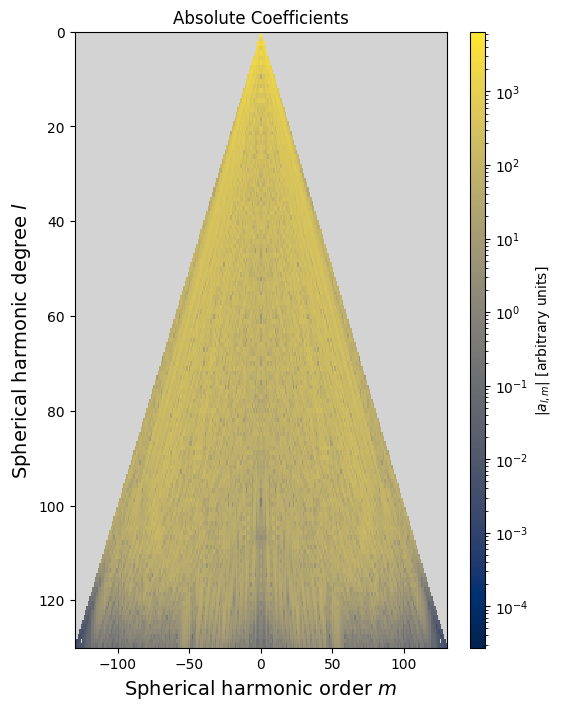

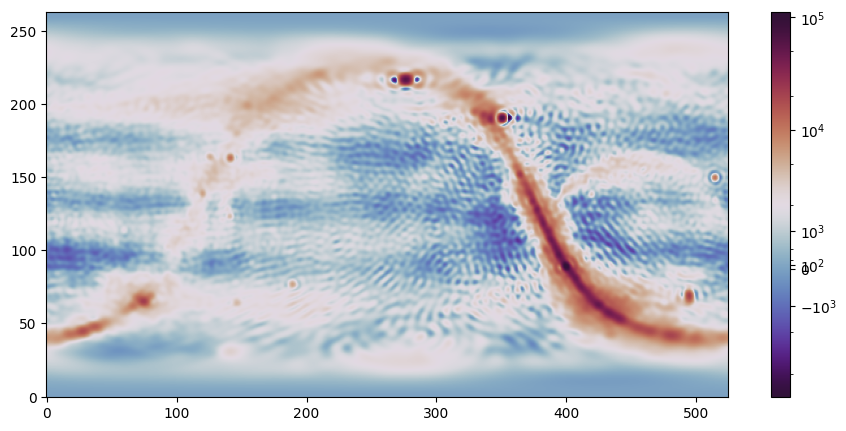

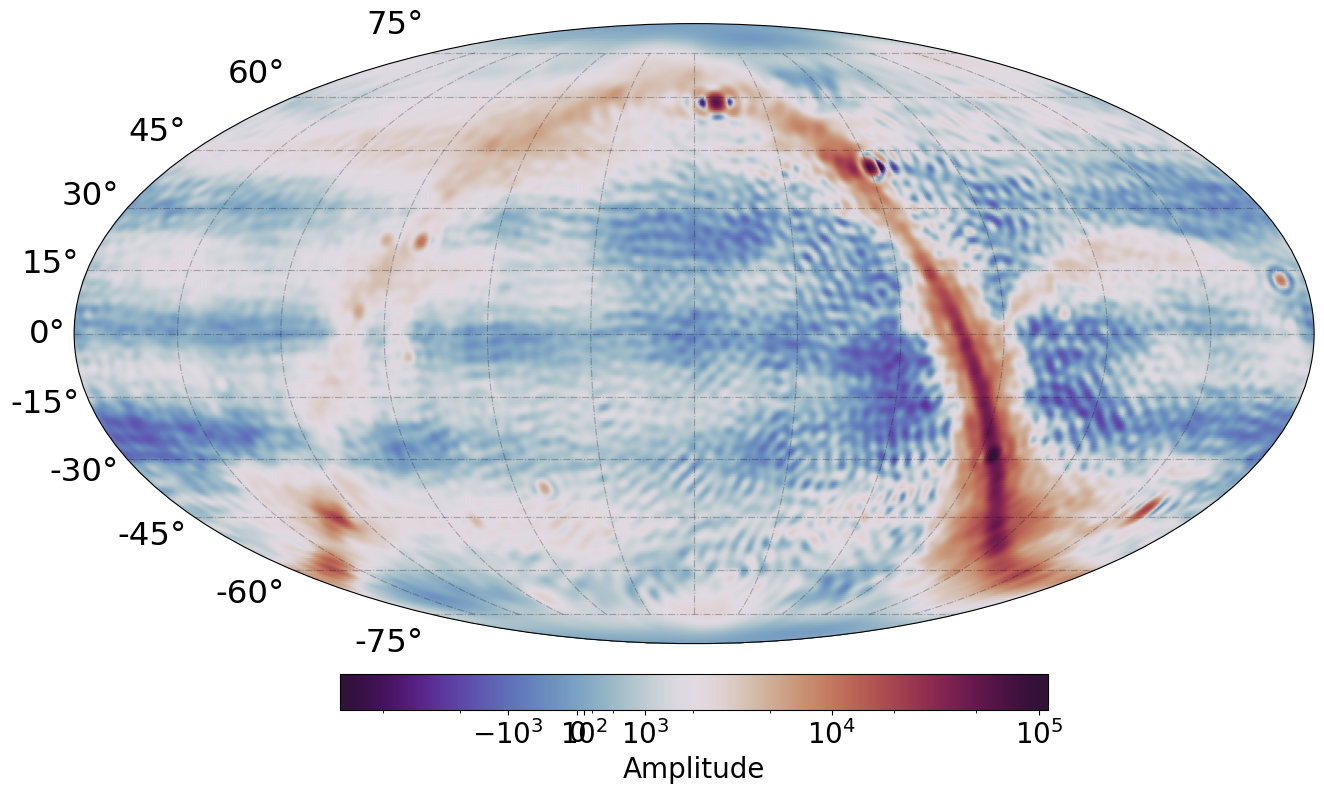

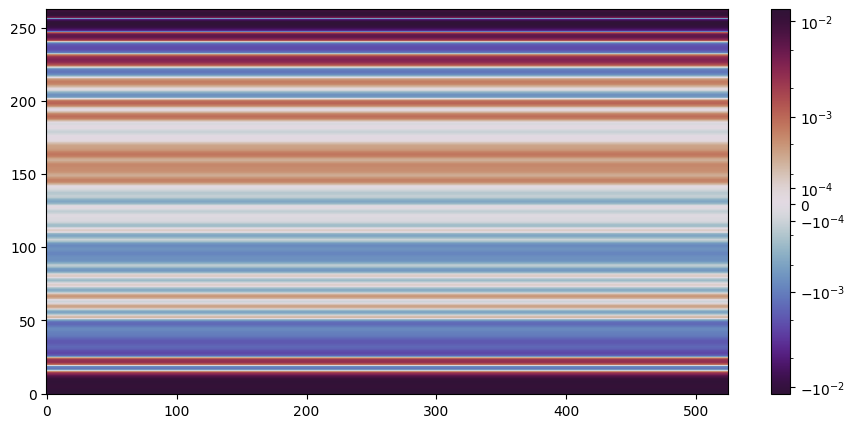

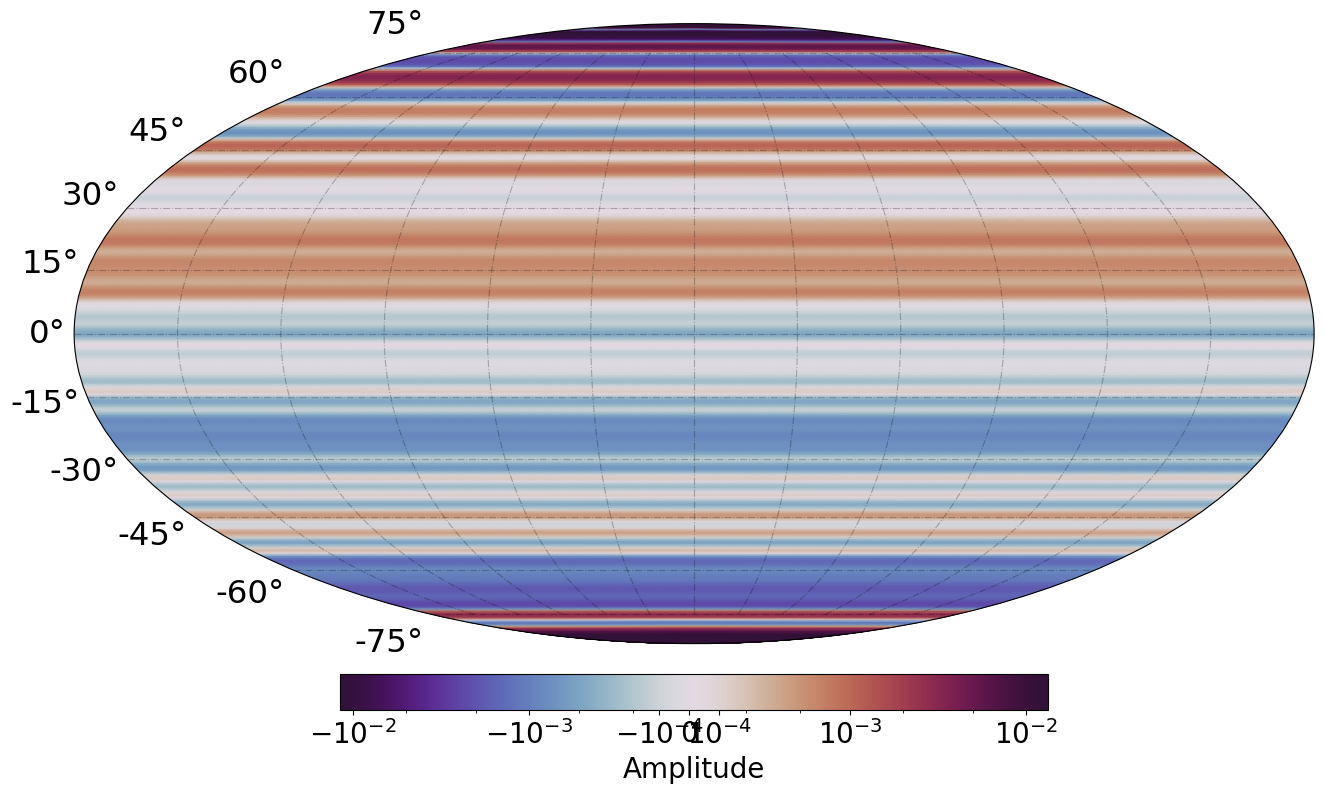

In [6]:
from mmode_tools.clean import plot_dirty_image
from mmode_tools.plots import coefficient_plot,plot_equatorial_map

#
coefficient_plot(dirtyCoeffs,norm='log',cmap='cividis',interpolation='None')

#
plot_dirty_image(dirtyMap.real,norm='asinh')
plot_equatorial_map(dirtyMap.real,norm='asinh')

#
plot_dirty_image(dirtyMap.imag,norm='asinh')
plot_equatorial_map(dirtyMap.imag,norm='asinh')


## Fitting from the Covariance Tensor

Now we demonstrate the old method of creating the dirty maps, going from the covariance tensor all the way to the dirty map and coefficients.

We use the function ```read_LST_VisCube``` to load the LST time vector (in units of hours) and the covariance tensor.

In [7]:
from mmode_tools.io import read_LST_VisCube
from mmode_tools.vistools import vis2mmode_DFT
from mmode_tools.plots import plot_baseline_fringes

# We assume the data is in xx instrumental polarisation, in reality it is stokes I,
# but for real data this will not be the case.
pol = 'xx'
lstVec,covTensor = read_LST_VisCube(covTensorPath+covTensorFileName,
                                    verbose=True,applyFlags=False,
                                    stokes=pol)




<KeysViewHDF5 ['data', 'flags']>
<KeysViewHDF5 ['covtxx', 'covtxy', 'covtyx', 'covtyy', 'lst', 'tGPS']>
Loading xx instrumental polarisation.
LST vector size/shape = (520,)
Visibility cube shape = (520, 32, 32)
Nant = 32


We test that the covariance matrix is loaded correctly by plotting some of the baseline fringes. In this example base (14,1) where Antind1 = 14 and Antind2 = 1.

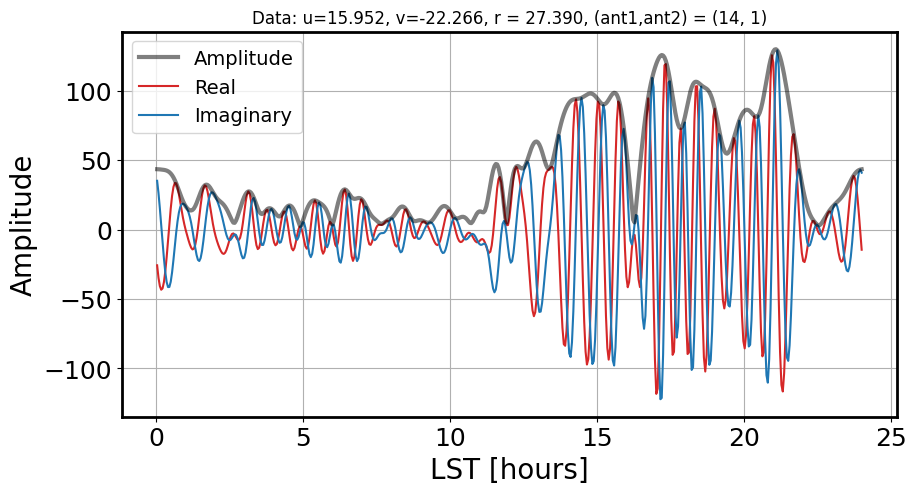

In [8]:
plot_baseline_fringes(lstVec,covTensor,(14,1),interferometer)

Next we create the mmode tensor. This step is a little clunky. We first DFT each baseline in the covariance tensor, which outputs a complex64 numpy array with shape (2,lmax+1,Nant,Nant). This then sorted into a more useful format (Nblines,2,lmax+1). The latter format is necessary to perform the inversion. 


In [9]:
Ncells = int(2*lMax+2)
tempMmodeTensor = vis2mmode_DFT(covTensor,lstVec,np.arange(lstVec.size),Ncells)



The next step sorts the temporary mmode tensor into the correct format. For a single instrument this is a trivial task and could be done simply by reshaping the array, or by applying a mask (filtering flagged baselines, and autocorrelations in one go). The approach used here was designed to work with $N$ number of instruments.

In [10]:
blines,antPairs = interferometer.get_baselines(interferometer)

# Including the conjugate baselines, but not the auto correlations.
NblineTot = covTensor[0,:,:].size - covTensor.shape[-1]

blineInd = 0
mmodeTensor = np.zeros([NblineTot,2,int(Ncells/2)],dtype=np.complex64)
# Looping through all baseline pairs and assigning to matrix.
for j in range(antPairs.shape[0]):
    ant1,ant2 = antPairs[j].astype(int)
    try:
        mmodeTensor[blineInd,:,:] += tempMmodeTensor[:,:,ant1,ant2]
    except IndexError:
        errMsg = f"Index error in calculation for {interferometer.telescope}."
        raise IndexError(f"{errMsg}\n{covTensor.shape}"+\
                            f"\n{tempMmodeTensor.shape}"+\
                            f"\n{mmodeTensor[blineInd,:,:].shape}")
    blineInd += 1

Next we have to load in the beam fringe coefficients for the instrument. 

In [11]:

beamFringePath = get_config_directory(pathName="beamFringePath")

# This should be the standard naming convention.
beamFileName = f"beam_fringe_coeffs-{name}-{freqMHz}MHz-I-lMax{lMax}.hdf5"

# The total path to the beam fringe coefficients. 
beamFringeFilePath = beamFringePath + beamFileName

if not os.path.exists(beamFringeFilePath):
    # If the coefficients don't exist, we can make them from scratch.
    from mmode_tools.beam import bline2alm
    from mmode_tools.examples import load_default_beam_model
    beamModel = load_default_beam_model(LAT=interferometer.lat,
                                        lMax=lMax,freq=freq,pol='I')
    blines,antPairs = interferometer.get_baselines(interferometer)
    blmCoeffTensor = bline2alm(blines,beamModel,freq,interferometer.lat,lMax)
    blmCoeffTensor = blmCoeffTensor[:,0,:,:] # Only need the positive mmodes.
else:
    # Otherwise we simply load them into existence. 
    blmCoeffTensor = load_beam_fringe_coef(beamFringeFilePath,lmax=lMax,
                                           verbose=True)

lmax= 130
CoeffTensor.shape = (992, 131, 131)
CoeffTensor size = 0.127 GB
Dataset size = 0.127 GB


Now we have the data and the instrument tensor, we can perform the inversion. 

In [12]:
from mmode_tools.inversion import invert_tikh_multi_assym as invert

weights = np.ones(mmodeTensor.shape[0])

skyCoTensor=invert([blmCoeffTensor],np.conj(mmodeTensor),lmax=lMax,
                   rtol=1e-4,verbosity=verbosity,damp=damp,njobs=1,
                   weights=weights)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:    0.4s finished


For the output coefficients to be useful, they have to be parsed into a ```pyshtools``` ```SHCoeffs``` object. From here we can generate the map (among other useful functions like plotting the power spectrum, see ther ```pyshtools``` wiki for more details). In this case we simply create the dirtyMap.

In [13]:
from pyshtools import SHCoeffs

SHcoeffs = SHCoeffs.from_array(skyCoTensor,normalization='ortho',csphase=-1)
griddedCoeffs = SHcoeffs.expand(grid='DH2',backend='ducc',lmax_calc=lMax)

# Creating the map.
dirtyMap = griddedCoeffs.data

Now we plot the results:

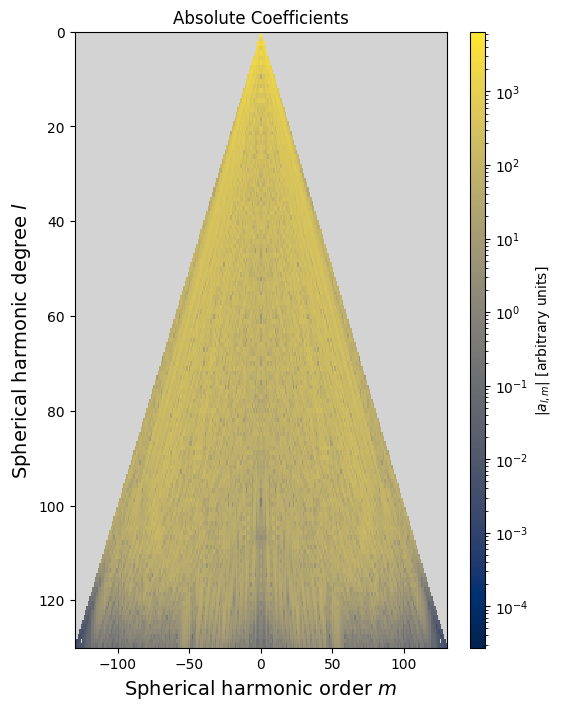

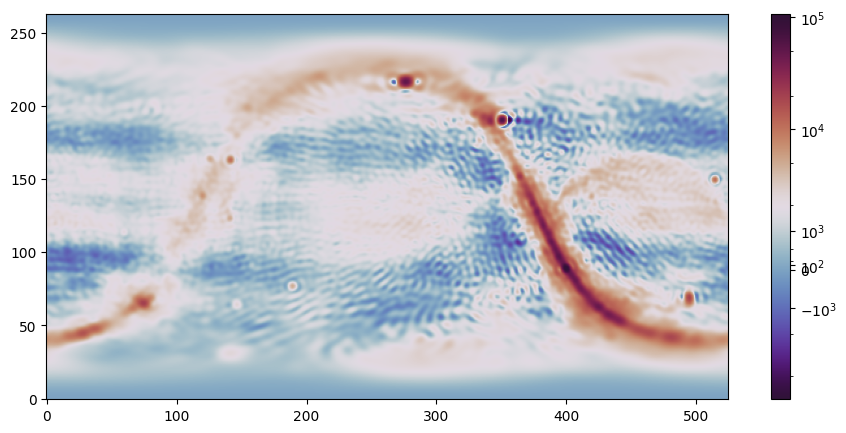

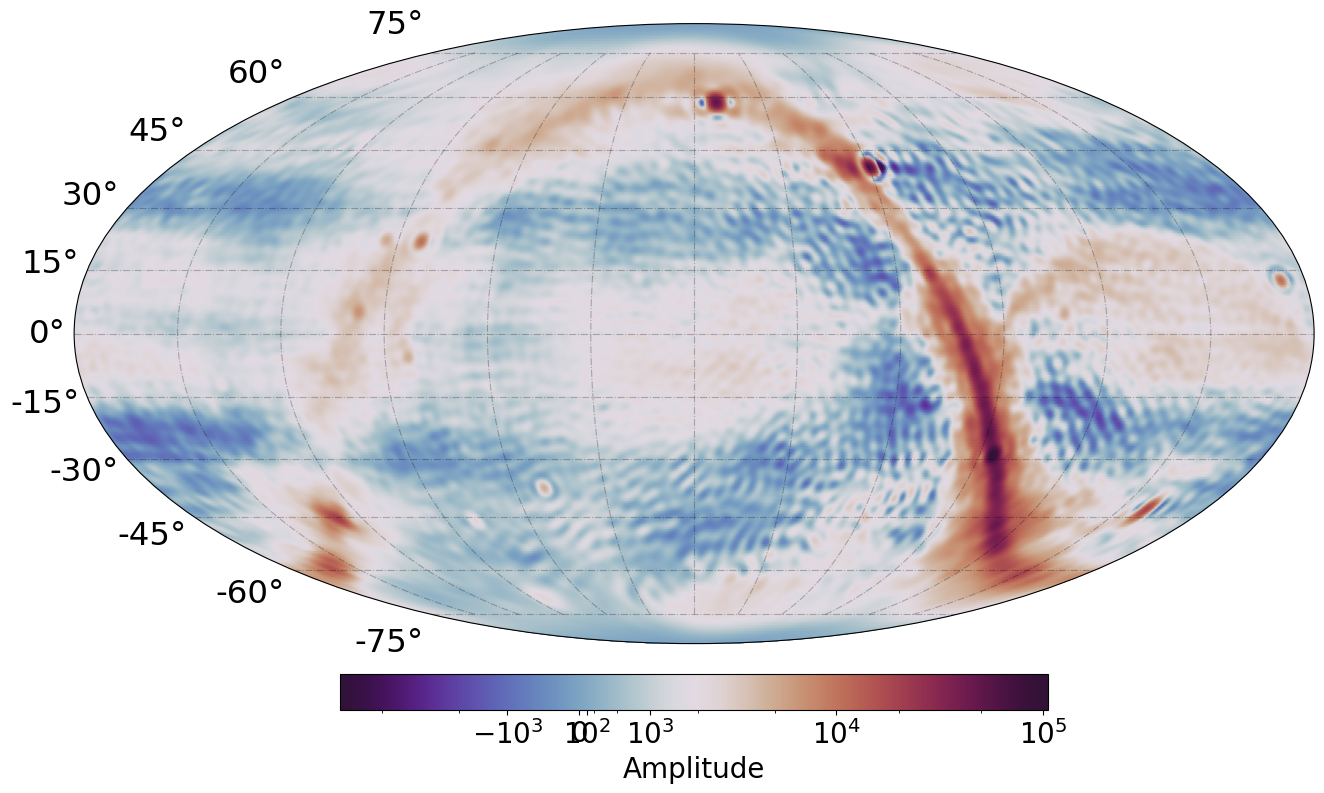

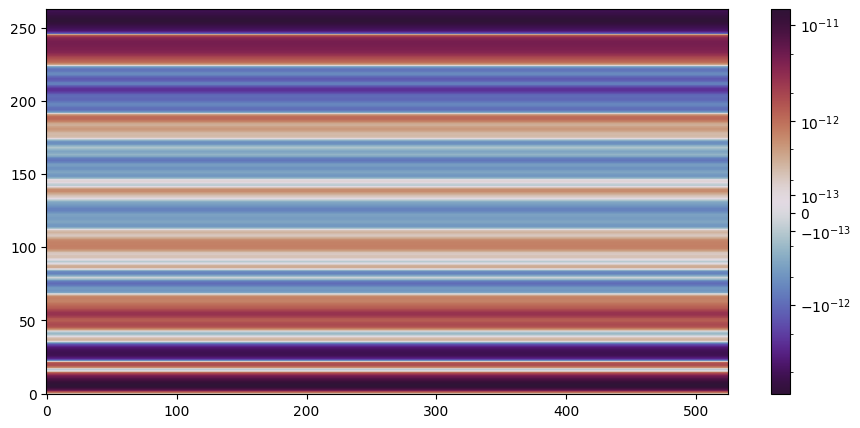

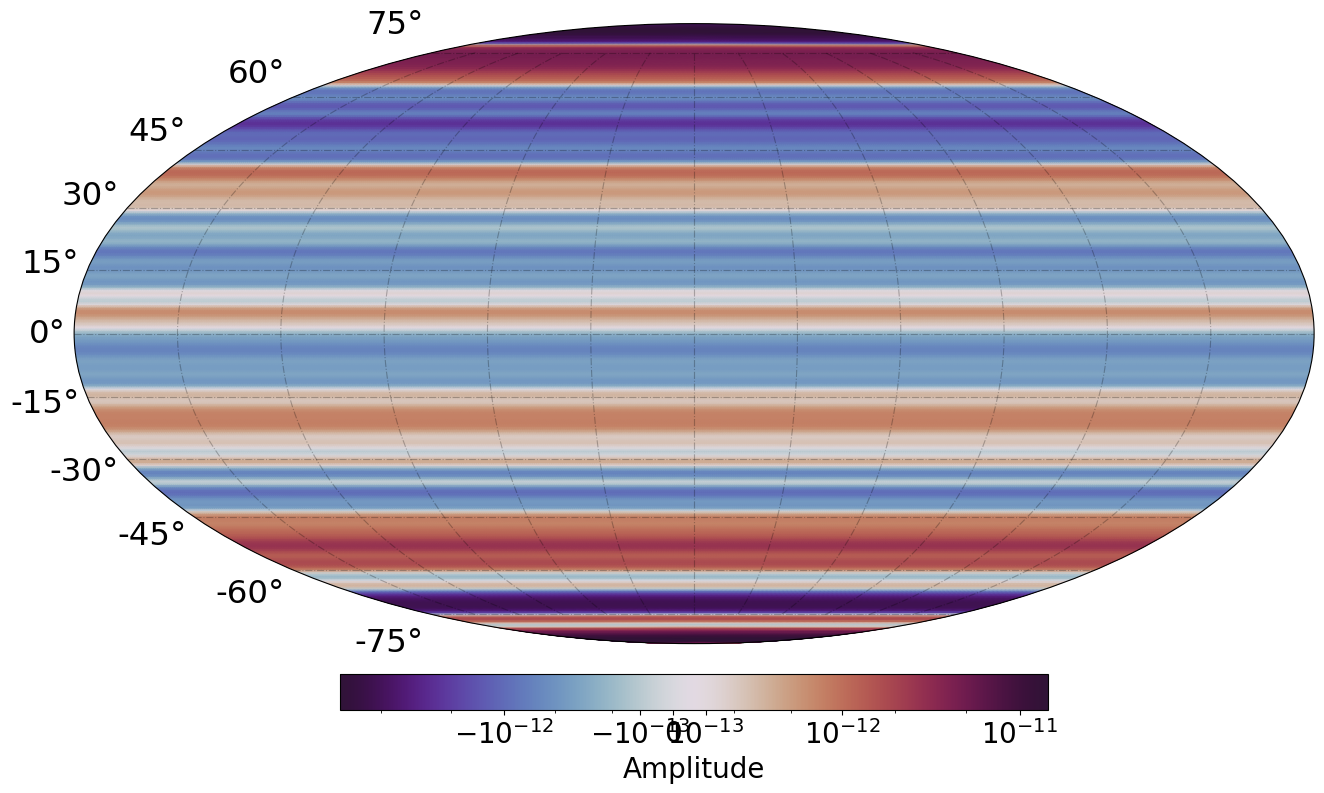

In [14]:
#
coefficient_plot(dirtyCoeffs,norm='log',cmap='cividis',interpolation='None')

#
plot_dirty_image(dirtyMap.real,norm='asinh')
plot_equatorial_map(dirtyMap.real,norm='asinh')

#
plot_dirty_image(dirtyMap.imag,norm='asinh')
plot_equatorial_map(dirtyMap.imag,norm='asinh')

## Saving the output map

Next we save the output map to a FITS file. The projection of this map is "plate carrée" or "RA--CAR" in the FITS header. We also optionally save the sky coefficients to the fits file as as a different hdu object. Separately saving the coefficients is useful, because reconstructing them from the image results in a different set of coefficients. This is due to the inherent limitations of SH-expansion with a finite $l$.

In [16]:
from mmode_tools.io import map2fits

saveCond = False

dirtyCoeffsPath = get_config_directory(pathName="dirtyCoeffsPath")
dirtyCoeffsFileName = f"test_{name}_{freqMHz}MHz_lmax{lMax}.fits"

#
if saveCond:
    map2fits(dirtyMap.real,freq,dirtyCoeffsPath+dirtyCoeffsFileName,
             skyCoeffs=dirtyCoeffs,verbose=True)

Printing hdu and header information...
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   (525, 263)   float64   
  1  SKY_COEFFS    1 BinTableHDU     13   17161R x 2C   ['E', 'E']   
None
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  525                                                  
NAXIS2  =                  263                                                  
EXTEND  =                    T                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                262.5 / Pixel coordinate of reference point            
CRPIX2  =                131.5 / Pixel coordinate of referenc

## Conclusion

We demonstrated the two methods for making dirty maps with ```mmode_tools``` from the same input data. Under the hood, ```mmode_tools``` "should" (emphasis on the should) be performing the same inversion on the data. The next step is to clean the resulting dirty images.